## Comparing retention

1. Compare daily retention curve for the Feb 4 and Feb 10 cohorts.
2. Compare daily retention by referral (google, facebook)

I could probably have done this with Pandas, but I wanted to try raw Python for fun.


In [8]:

from collections import defaultdict
import json
import matplotlib.pyplot as plt


DAYS_IN_MONTH = 28  # february
DATA_FILE = 'data/pings.txt' # 750MB, so not committed
SUBSAMPLE_FILE = 'data/minipings.json'  # subset of users
MAKE_SUBAMPLE = False 
USE_SUBSAMPLE = True # keep to True unless you have pings.txt
    

In [9]:

def make_subsample(whole_file, subsample_file):
    """ subsample 1/100 into separate file """
    line_counter = 0
    with open(whole_file, 'r') as rf, open(subsample_file, 'w') as wf:
        for line_txt in rf:
            try:
                uid = json.loads(line_txt)['attributed_to']
                if uid[-1] == '0' and uid[-2] == '0': # 1/100 subsample
                    wf.write(line_txt)
            except:
                print('Error parsing line_txt:', line_txt)
            line_counter += 1
            if line_counter % 10 ** 6 == 0:
                print('read %dM lines' % (line_counter // 10 ** 6))
    

def parse_lines(filename):
    """ Generator that opens the file and parses its JSON lines. 
    Return tuple:
        user id (str), 
        days since feb 1 (int), 
        is install day (bool, False if missing), 
        first_utm_source (str, 'unknown' if missing).
    """
    line_counter = 0
    with open(filename, 'r') as rf:
        for line_txt in rf:
            try:
                d = json.loads(line_txt)
                tup = (
                    d['attributed_to'],
                    int(d['date_time'][8:10]),
                    d.get('used_first_time_today', False),
                    d.get('first_utm_source', 'unknown') 
                    )
            except:
                print('Error parsing line_txt:', line_txt)
            line_counter += 1
            if line_counter % 10 ** 6 == 0:
                print('read %dM lines' % (line_counter // 10 ** 6))
            yield tup  # yield: https://stackoverflow.com/a/231855

            
def parse_pings(filename):
    """ return a 3-tuple of:
        users_days = defaultdict(set)  # map user to days seen (int set)
        users_referrals = {}  # map user to referral of first visit (str)
        cohorts = defaultdict(set)  # map day to users born that day (str set)
    """
    users_days = defaultdict(set)  # map user to days seen 
    users_referrals = {}  # map user to referral of first visit
    cohorts = defaultdict(set)  # map day to users born that day

    print('parsing file %s' % filename)
    for (uid, day, isnew, referral) in parse_lines(filename):
        users_days[uid].add(day)  # TODO: bitmask instead of set? days[uid] |= 1 << day
        if isnew:
            users_referrals[uid] = referral
            cohorts[day].add(uid)
    print('finished reading file %s' % filename)
    return users_days, users_referrals, cohorts


# make subsample
if MAKE_SUBAMPLE:
    make_subsample(DATA_FILE, SUBSAMPLE_FILE)

# parse sampkle or subsample
filename = SUBSAMPLE_FILE if USE_SUBSAMPLE else DATA_FILE
users_days, users_referrals, cohorts = parse_pings(filename)

parsing file data/minipings.json
finished reading file data/minipings.json


In [10]:

def compute_retention(cohorts, users_days, bday):
    """ compute 14d retention for cohort born on bday """
    users_seen = [0 for _ in range(14 + 1)]  # from bday to bday + 14 days
    for uid in cohorts[bday]:
        for dayofmonth in users_days[uid]:
            if dayofmonth <= bday + 14:
                users_seen[dayofmonth - bday] += 1
    ret = [n * 1.0 / users_seen[0] for n in users_seen]
    return ret

# compute d1-d14 retention for 2 cohorts
rets = {bday: compute_retention(cohorts, users_days, bday) for bday in [4,10]}


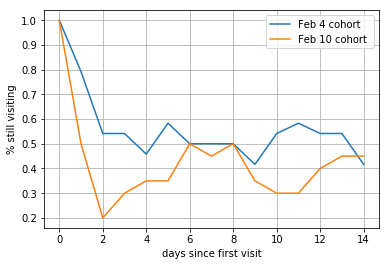

In [11]:
# plot
for bday, ret in rets.items():
    plt.plot(range(len(ret)), ret, label=('Feb %d cohort ' % bday))
plt.xlabel('days since first visit')
plt.ylabel('% still visiting')
plt.grid(True)
plt.legend()
plt.show()

**Take-away**: Feb 4 cohort retains better than Feb 10.

In [17]:
MIN_SUBGROUP_SIZE = 20

def compute_retention_by_referral(cohorts, users_days, users_referrals):
    """ compute 14d retention by referral for cohort born on bday """
    users_seen_by_ref = {} # fill this up
    
    # compute d0-d14 user counts by ref source
    for bday in range(14): # can compute d14 ret for first 14d cohorts
        for uid in cohorts[bday]:
            ref = users_referrals[uid]
            for dayofmonth in users_days[uid]:
                if dayofmonth >= bday and dayofmonth <= bday + 14:
                    # add empty list if not there yet
                    if ref not in users_seen_by_ref: 
                        users_seen_by_ref[ref] = [0 for _ in range(14 + 1)]  # from bday to bday + 14 days
                    users_seen_by_ref[ref][dayofmonth - bday] += 1

    # merge all sources bringing too few users in 14d into 'others'
    others_days_seen = [0 for _ in range(14 + 1)]
    others_names = set() # sources merged into 'others'
#     for ref, users_seen in users_seen_by_ref.items():
    for ref in list(users_seen_by_ref.keys()):
        users_seen = users_seen_by_ref[ref]
        if users_seen[0] < MIN_SUBGROUP_SIZE:
            others_days_seen = [x + y for x,y in zip(others_days_seen, users_seen)]
            others_names.add(ref)
            del users_seen_by_ref[ref]
    users_seen_by_ref['others'] = others_days_seen
    print('merged into others: ' + ', '.join(sorted(others_names)))
    
    # divide daily user counts by d0
    rets = {}
    for ref, users_seen in users_seen_by_ref.items():
        rets[ref] = [n * 1.0 / users_seen[0] for n in users_seen]
        print('%s brought %d users' % (ref, users_seen[0]))
    
    return rets

ref_rets = compute_retention_by_referral(cohorts, users_days, users_referrals)


merged into others: Facebook_org, answers, bing, brand1, display, facebook, pandora, placement, program, taboola
unknown brought 215 users
google brought 81 users
youtube brought 30 users
others brought 29 users


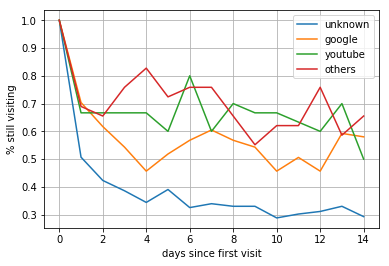

In [18]:
# plot
for ref, ret in ref_rets.items():
    plt.plot(range(len(ret)), ret, label=ref)
plt.xlabel('days since first visit')
plt.ylabel('% still visiting')
plt.grid(True)
plt.legend()
plt.show()

**Take-away**: youtube retains better than google.